**OTUS Machine Learning Professional**

### **Homework 6**

### Building a time series prediction model

![hw6p](https://user-images.githubusercontent.com/73858914/171476388-329bdb16-898d-46c4-ba66-6233dabb7244.png)

**Goals:**

1. Download and clean "Metropolitan Interstate Traffic Volume" dataset;
2. Explore data;
3. Engineer additional features;
4. Build a baseline model - average by day of week and hour;
5. Build and test a number of models and compare results with the baseline;
6. Make predictions of temperature for test set and use it in model;
7. Visualize best model with confidence intervals.

**Means**:

- All time series exploration and prognosis are done with [Pycaret-ts-alpha](https://pypi.org/project/pycaret-ts-alpha) library

**Data source**:

[UCI Machine Learning Repository: Metro Interstate Traffic Volume Data Set](https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume)

**Binder notebook:**

main.ipynb

### Import libraries

In [1]:
# !pip install catboost

In [2]:
%%capture
!pip install pycaret-ts-alpha

In [3]:
def what_is_installed():
    from pycaret import show_versions
    show_versions()

try:
    what_is_installed()
except ModuleNotFoundError:
    !pip install pycaret-ts-alpha
    what_is_installed()


System:
    python: 3.7.13 (default, Apr 24 2022, 01:04:09)  [GCC 7.5.0]
executable: /usr/bin/python3
   machine: Linux-5.4.188+-x86_64-with-Ubuntu-18.04-bionic

Python dependencies:
          pip: 21.1.3
   setuptools: 57.4.0
      pycaret: 3.0.0
      sklearn: 1.0.2
       sktime: 0.10.1
  statsmodels: 0.13.2
        numpy: 1.21.6
        scipy: 1.7.3
       pandas: 1.3.5
   matplotlib: 3.5.2
       plotly: 5.5.0
       joblib: 1.0.1
        numba: 0.55.2
       mlflow: Not installed
     lightgbm: 3.3.2
      xgboost: 0.90
     pmdarima: 1.8.5
        tbats: Installed but version unavailable
      prophet: Not installed
      tsfresh: Not installed


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML

# from jupyterthemes import jtplot
import warnings

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

from pycaret.time_series import *

warnings.filterwarnings("ignore")

###  Miscellaneous settings

In [5]:
%matplotlib inline
display(HTML("<style>.container { width:80% !important; }</style>"))
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = (12, 4)
plt.style.use("ggplot")
pd.options.display.precision = 4

### ML settings

In [6]:
random_state = 17

### Import data

In [7]:
!cd sample_data
!mkdir data

mkdir: cannot create directory ‘data’: File exists


In [8]:
df0 = pd.read_csv(
    "./data/Metro_Interstate_Traffic_Volume.csv.gz",
    infer_datetime_format=True,
    compression="gzip")
df = df0.copy()
df["date_time"] = pd.to_datetime(df["date_time"])
df.index = df["date_time"]
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
date_time,,,,,,,,,
2012-10-02 09:00:00,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
2012-10-02 10:00:00,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2012-10-02 11:00:00,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
2012-10-02 12:00:00,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
2012-10-02 13:00:00,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


###  EDA

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48204 entries, 2012-10-02 09:00:00 to 2018-09-30 23:00:00
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   holiday              48204 non-null  object        
 1   temp                 48204 non-null  float64       
 2   rain_1h              48204 non-null  float64       
 3   snow_1h              48204 non-null  float64       
 4   clouds_all           48204 non-null  int64         
 5   weather_main         48204 non-null  object        
 6   weather_description  48204 non-null  object        
 7   date_time            48204 non-null  datetime64[ns]
 8   traffic_volume       48204 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 3.7+ MB


#### Traffic data

#####  Check duplicate rows

In [10]:
print(f"Number of datapoints:  {df.shape[0]}\nUnique timestamps: {df.index.nunique()}")

Number of datapoints:  48204
Unique timestamps: 40575


Dataset has roughly 16% of duplicates

##### Visual inspection of traffic

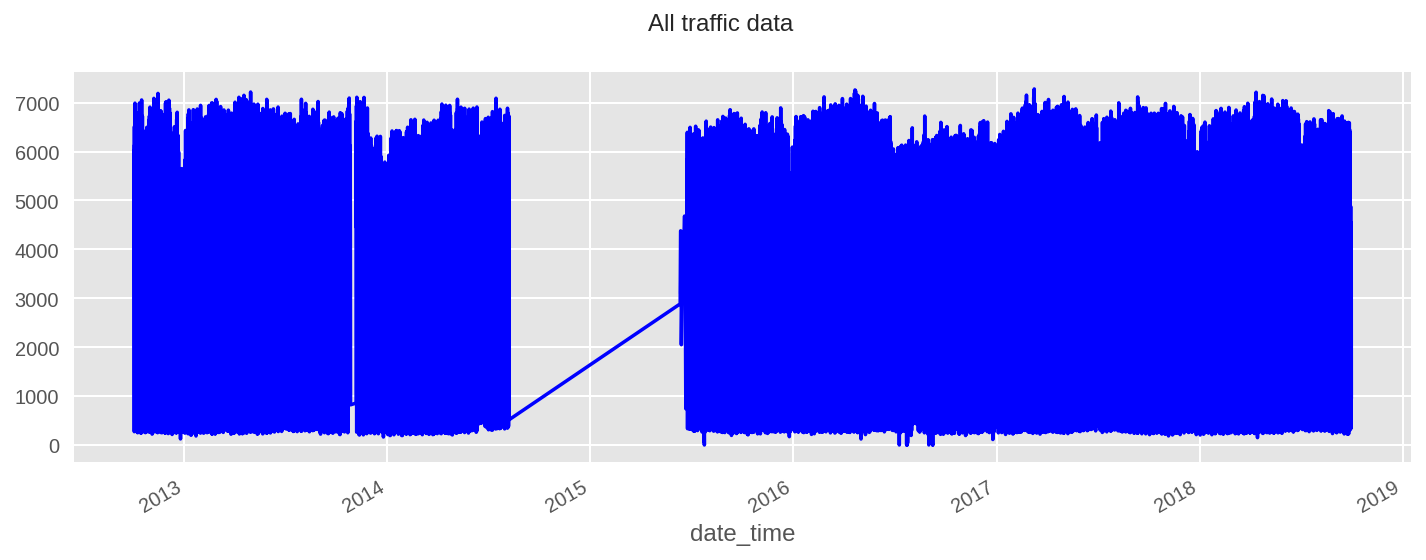

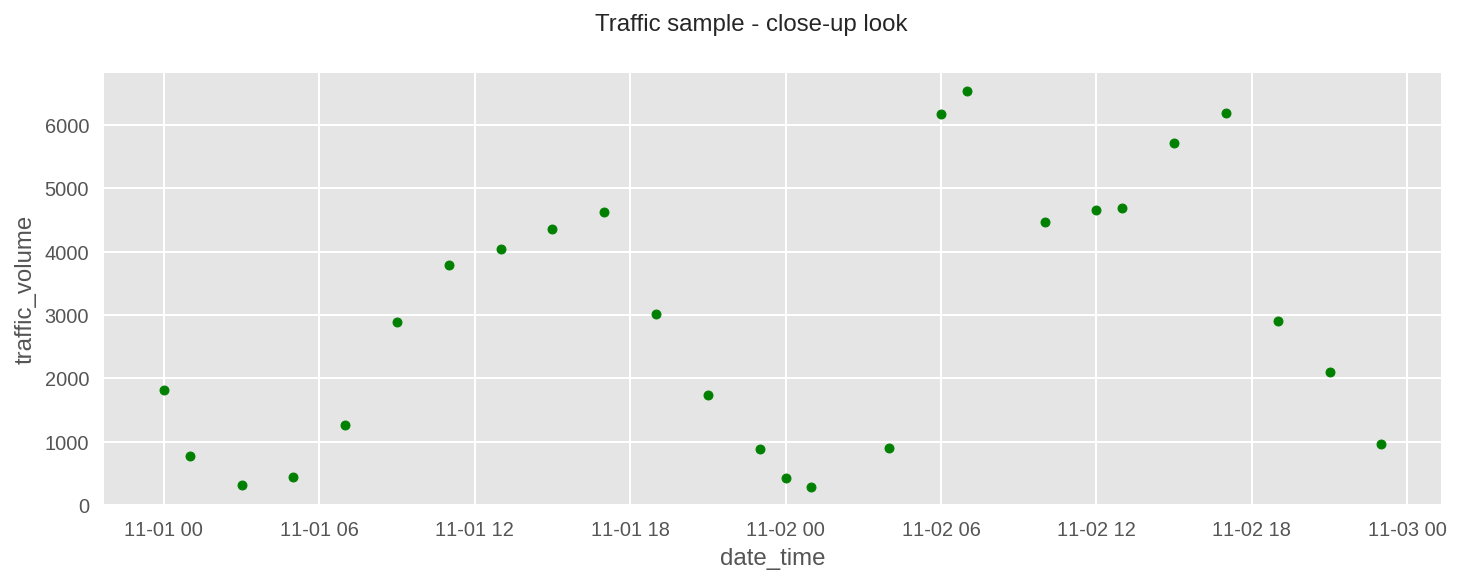

In [11]:
_ = df["traffic_volume"].plot(color='blue')
plt.suptitle("All traffic data")
plt.show()
s0 = df.loc["2015-11-01":"2015-11-02"]
s0.plot.scatter("date_time", "traffic_volume", color="green")
plt.suptitle("Traffic sample - close-up look")
plt.show()

Observations: 
* There is a huge gap in data in 2015;  
* Daily plot shows quite a few missing data.  

We have two alternatives to deal with data in 2015:
* Drop all data before 1 July 2015;
* Join data before 1 July 2014 and after 1 July 2015,   
adjusting the year values in the first part.  

It seems that we have enough contigious data in the 2015-2018 span,   
so we will chose the first, simpler approach.

### Data preprocessing

#### Drop data before 1 July 2015

In [12]:
df = df["2015-07-01":].sort_index()

#### Drop duplicates

In [13]:
df = df[~df.index.duplicated(keep="first")]

#### Add missing DateTimeStamps

In [14]:
idx = pd.date_range(min(df.date_time), max(df.date_time), freq="1H")
df2 = pd.DataFrame(index=idx)
df = df2.join(df, on=df2.index, how="outer")

####  Interpolate data in columns

In [15]:
df["traffic_volume"].interpolate(method="piecewise_polynomial", inplace=True)
df["temp"].interpolate(method="piecewise_polynomial", inplace=True)

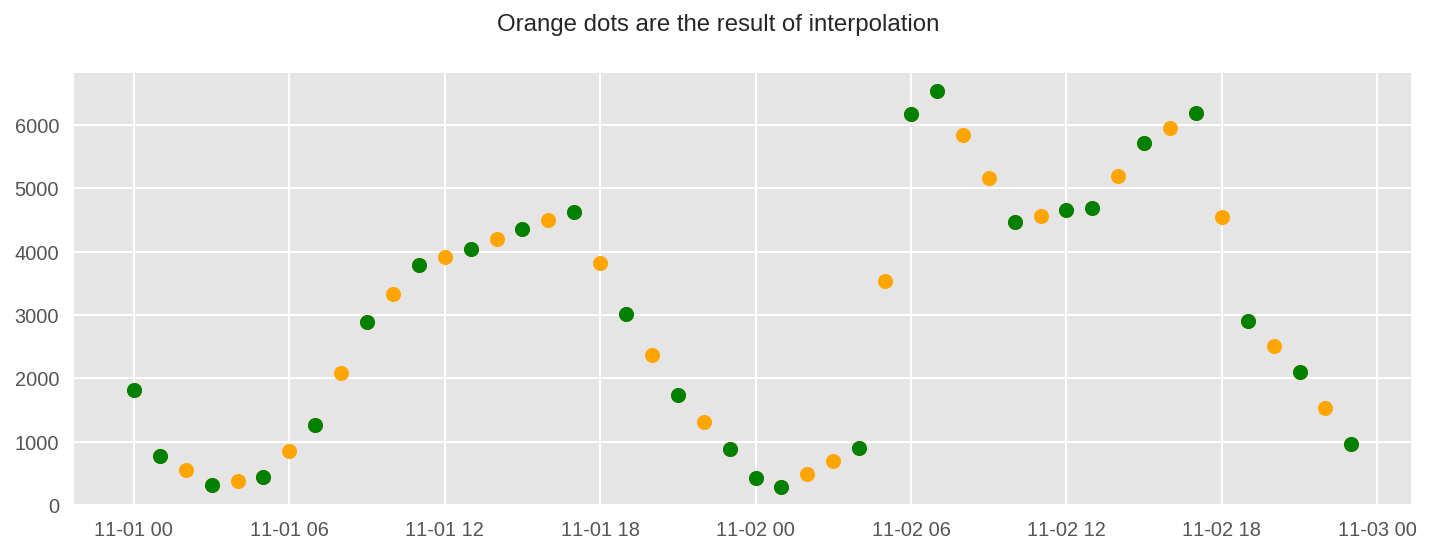

In [16]:
plt.scatter(
    df["2015-11-01":"2015-11-02"].index,
    df.loc["2015-11-01":"2015-11-02"]["traffic_volume"],
    color="orange",
)
plt.scatter(s0.index, s0["traffic_volume"], color="green")
plt.suptitle("Orange dots are the result of interpolation ")
plt.show()

In [17]:
df.head()

,key_0,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
2015-07-01 00:00:00,2015-07-01 00:00:00,None,289.20,0.0,0.0,1.0,Clear,sky is clear,2015-07-01 00:00:00,737.0
2015-07-01 01:00:00,2015-07-01 01:00:00,None,289.40,0.0,0.0,1.0,Clear,sky is clear,2015-07-01 01:00:00,444.0
2015-07-01 02:00:00,2015-07-01 02:00:00,None,289.19,0.0,0.0,1.0,Clear,sky is clear,2015-07-01 02:00:00,347.0
2015-07-01 03:00:00,2015-07-01 03:00:00,None,288.74,0.3,0.0,1.0,Rain,light rain,2015-07-01 03:00:00,356.0
2015-07-01 04:00:00,2015-07-01 04:00:00,None,288.07,0.0,0.0,1.0,Clear,sky is clear,2015-07-01 04:00:00,936.0


#### Inspect resulting dataframe

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 28512 entries, 2015-07-01 00:00:00 to 2018-09-30 23:00:00
Freq: H
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   key_0                28512 non-null  datetime64[ns]
 1   holiday              26528 non-null  object        
 2   temp                 28512 non-null  float64       
 3   rain_1h              26528 non-null  float64       
 4   snow_1h              26528 non-null  float64       
 5   clouds_all           26528 non-null  float64       
 6   weather_main         26528 non-null  object        
 7   weather_description  26528 non-null  object        
 8   date_time            26528 non-null  datetime64[ns]
 9   traffic_volume       28512 non-null  float64       
dtypes: datetime64[ns](2), float64(5), object(3)
memory usage: 3.4+ MB


####  Check holiday values

In [19]:
df["holiday"].value_counts().to_frame()

,holiday
None,26493
Independence Day,4
State Fair,4
Labor Day,4
Columbus Day,3
Veterans Day,3
Thanksgiving Day,3
Christmas Day,3
New Years Day,3
Washingtons Birthday,3


###  Feature engineering

#### Create periodic functions from hour, weekday and month data, add hour, weekday, weekend features, binarize holiday column.

In [20]:
df["weekend"] = (df.index.weekday > 4).astype(int)
df["hour_cos"] = -np.cos(((2 * np.pi * df.index.hour) / 24)) + 1
df["day_sin"] = np.sin(((2 * np.pi * (df.index.weekday) - 1) / 7)) + 1
df["month_cos"] = -np.cos(((2 * np.pi * (df.index.month) / 12))) + 1
df["holiday"] = df["holiday"].apply(lambda x: 0 if x == "None" else 1)
df["month"] = df.index.month
df["weekday"] = df.index.weekday
df["hour"] = df.index.hour

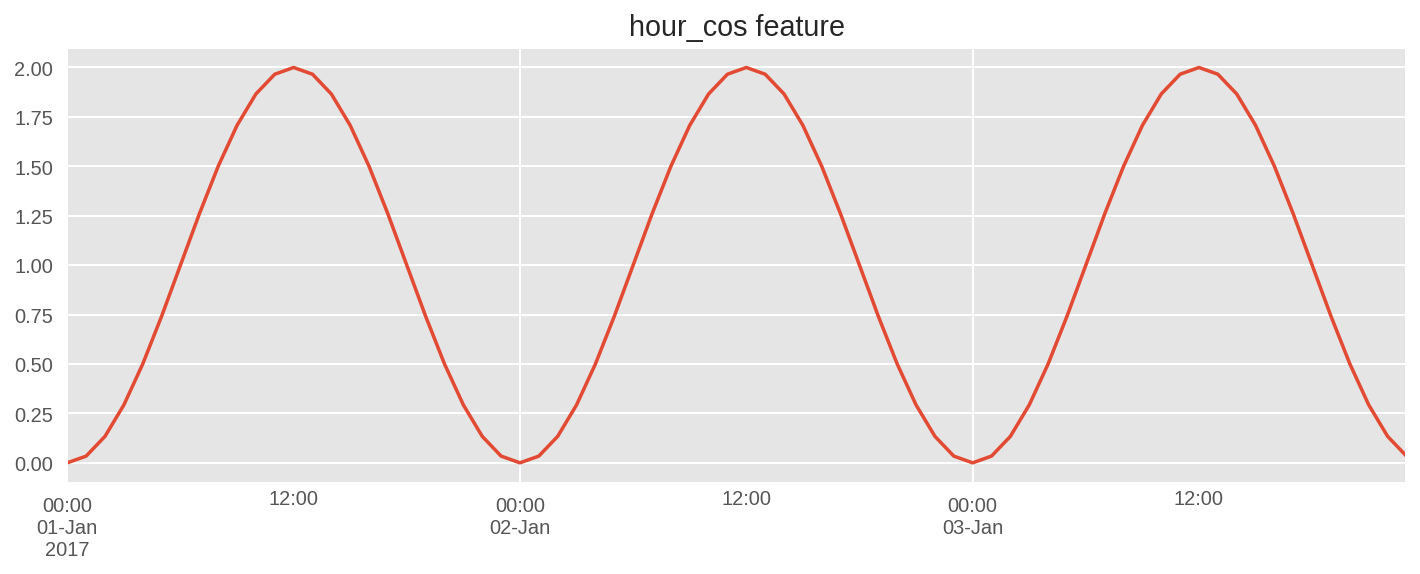

In [21]:
_ = df["2017-01-01":"2017-01-03"]["hour_cos"].plot(title="hour_cos feature")

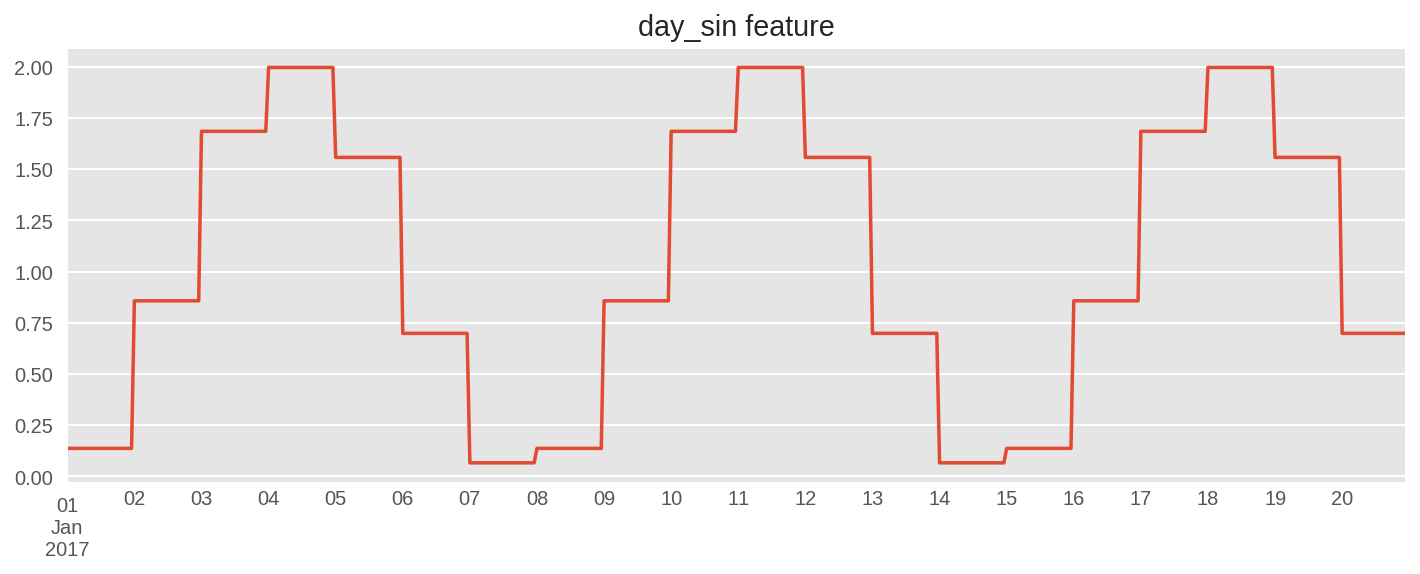

In [22]:
_ = df["2017-01-01":"2017-01-20"]["day_sin"].plot(title="day_sin feature")

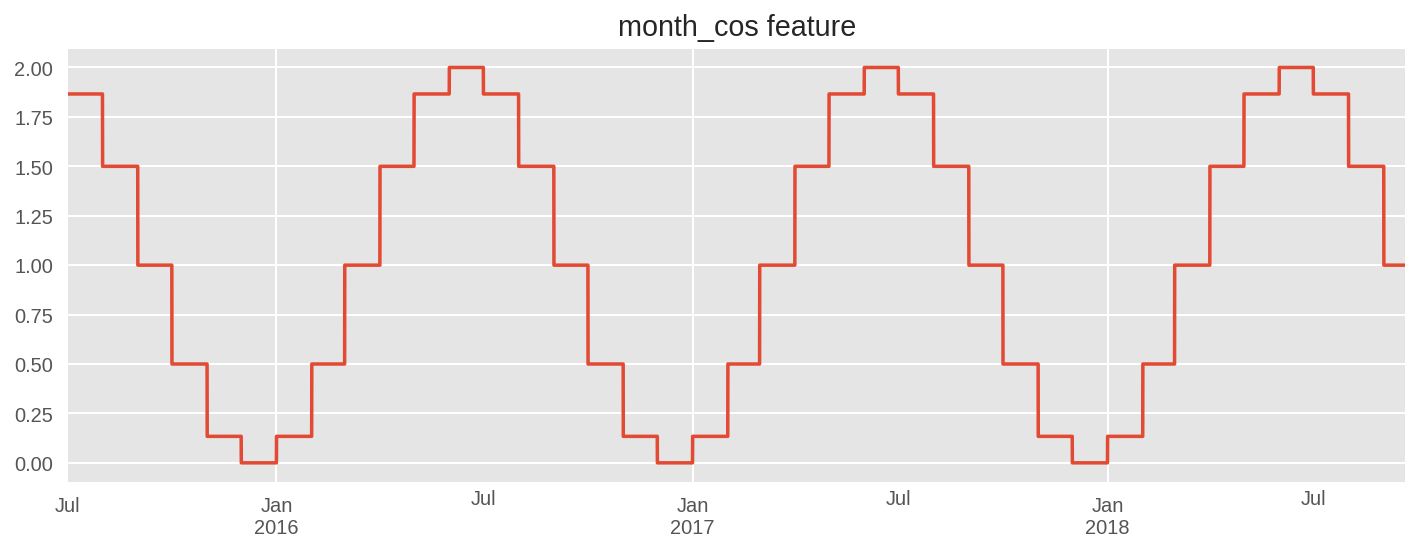

In [23]:
_ = df["2015-07-01":"2018-09-20"]["month_cos"].plot(title="month_cos feature")

In [24]:
df.head()

,key_0,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume,weekend,hour_cos,day_sin,month_cos,month,weekday,hour
2015-07-01 00:00:00,2015-07-01 00:00:00,0,289.20,0.0,0.0,1.0,Clear,sky is clear,2015-07-01 00:00:00,737.0,0,0.0000,1.9967,1.866,7,2,0
2015-07-01 01:00:00,2015-07-01 01:00:00,0,289.40,0.0,0.0,1.0,Clear,sky is clear,2015-07-01 01:00:00,444.0,0,0.0341,1.9967,1.866,7,2,1
2015-07-01 02:00:00,2015-07-01 02:00:00,0,289.19,0.0,0.0,1.0,Clear,sky is clear,2015-07-01 02:00:00,347.0,0,0.1340,1.9967,1.866,7,2,2
2015-07-01 03:00:00,2015-07-01 03:00:00,0,288.74,0.3,0.0,1.0,Rain,light rain,2015-07-01 03:00:00,356.0,0,0.2929,1.9967,1.866,7,2,3
2015-07-01 04:00:00,2015-07-01 04:00:00,0,288.07,0.0,0.0,1.0,Clear,sky is clear,2015-07-01 04:00:00,936.0,0,0.5000,1.9967,1.866,7,2,4


#### Drop unneeded columns

In [25]:
df.drop(
    columns=[
        "key_0",
        "rain_1h",
        "snow_1h",
        "clouds_all",
        "weather_main",
        "weather_description",
        "date_time",
    ],
    inplace=True,
)

In [26]:
new_cols = [
    "holiday",
    "weekday",
    "weekend",
    "hour",
    "hour_cos",
    "day_sin",
    "month",
    "month_cos",
    "temp",
    "traffic_volume",
]
df = df[new_cols]
df.head()

,holiday,weekday,weekend,hour,hour_cos,day_sin,month,month_cos,temp,traffic_volume
2015-07-01 00:00:00,0,2,0,0,0.0000,1.9967,7,1.866,289.20,737.0
2015-07-01 01:00:00,0,2,0,1,0.0341,1.9967,7,1.866,289.40,444.0
2015-07-01 02:00:00,0,2,0,2,0.1340,1.9967,7,1.866,289.19,347.0
2015-07-01 03:00:00,0,2,0,3,0.2929,1.9967,7,1.866,288.74,356.0
2015-07-01 04:00:00,0,2,0,4,0.5000,1.9967,7,1.866,288.07,936.0


### Train-test split for baseline model

In [27]:
df_train = df["2017-01-01":"2018-09-23"]
df_test = df["2018-09-24":"2018-09-30"]

###  Baseline model - mean by weekday and hour

In [28]:
yhat_gb = df_train.groupby(["weekday", "hour"])["traffic_volume"].mean()

In [29]:
for ix in df_test.index:
    df_test.loc[ix, "traffic_prediction"] = yhat_gb.loc[
        (df.loc[ix].weekday, df.loc[ix].hour)
    ]
yhat = df_test[-df_test.shape[0] :]["traffic_prediction"]
# yhat

In [30]:
df_test.tail()

,holiday,weekday,weekend,hour,hour_cos,day_sin,month,month_cos,temp,traffic_volume,traffic_prediction
2018-09-30 19:00:00,0,6,1,19,0.7412,0.1374,9,1.0,283.45,3543.0,3194.4945
2018-09-30 20:00:00,0,6,1,20,0.5000,0.1374,9,1.0,282.76,2781.0,2872.9670
2018-09-30 21:00:00,0,6,1,21,0.2929,0.1374,9,1.0,282.73,2159.0,2434.3956
2018-09-30 22:00:00,0,6,1,22,0.1340,0.1374,9,1.0,282.09,1450.0,1873.3516
2018-09-30 23:00:00,0,6,1,23,0.0341,0.1374,9,1.0,282.12,954.0,1272.9890


#### Baseline model predictions

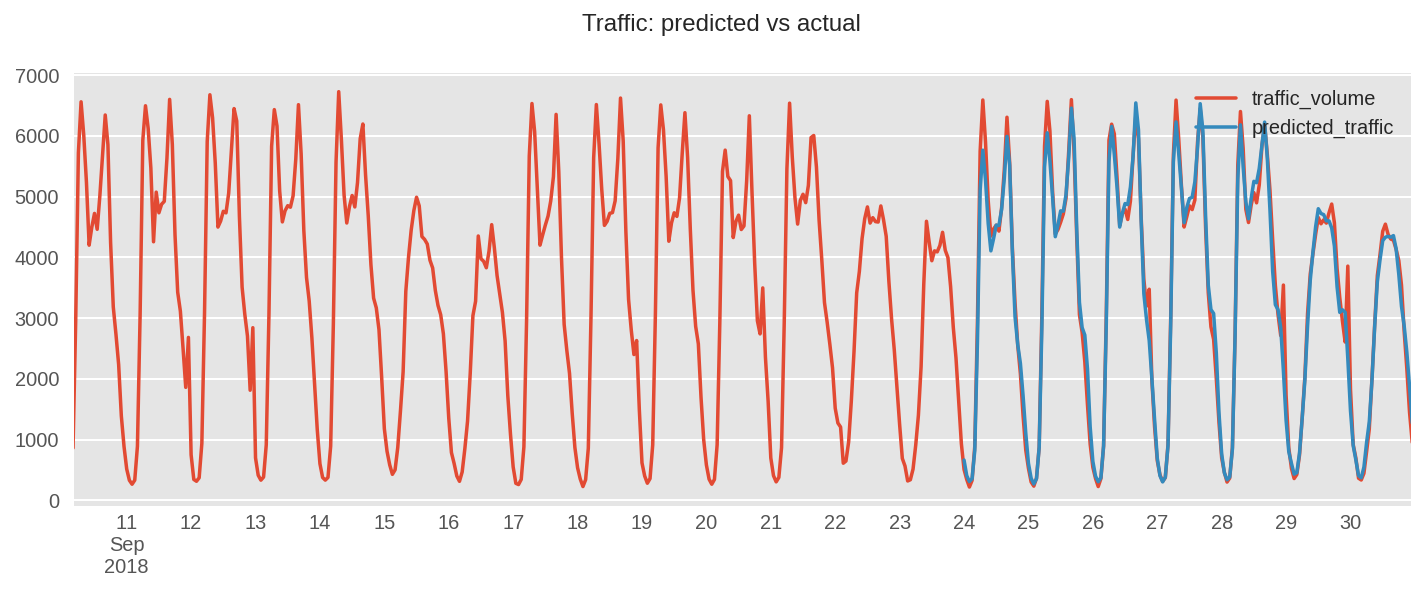

In [31]:
ix_plot = df_train.index.union(df_test.index)
df.loc[ix_plot[-500:]][["traffic_volume"]].plot()
yhat.plot(label="predicted_traffic")
plt.suptitle("Traffic: predicted vs actual")
plt.legend(loc="upper right")
plt.show()

#### RMSE metrics of baseline model

In [32]:
print(f"Base model MAE = {mae(df_test['traffic_volume'], yhat):.1f}")
print(f"Base model RMSE = {np.sqrt(mse(df_test['traffic_volume'], yhat)):.1f}")

Base model MAE = 183.8
Base model RMSE = 280.6


###  Pycaret regression

In [33]:
df1 = df.copy()
df1["traffic_volume"] = df1["traffic_volume"] + 1
df1.tail()

,holiday,weekday,weekend,hour,hour_cos,day_sin,month,month_cos,temp,traffic_volume
2018-09-30 19:00:00,0,6,1,19,0.7412,0.1374,9,1.0,283.45,3544.0
2018-09-30 20:00:00,0,6,1,20,0.5000,0.1374,9,1.0,282.76,2782.0
2018-09-30 21:00:00,0,6,1,21,0.2929,0.1374,9,1.0,282.73,2160.0
2018-09-30 22:00:00,0,6,1,22,0.1340,0.1374,9,1.0,282.09,1451.0
2018-09-30 23:00:00,0,6,1,23,0.0341,0.1374,9,1.0,282.12,955.0


#### Train-test split for Pycaret models

#### Choose between using only "traffic_volume" and all features

###### Use only "traffic_volume"

In [34]:
# df1.drop(
#     columns=[
#         "holiday",
#         "weekday",
#         "weekend",
#         "hour",
#         "hour_cos",
#         "day_sin",
#         "month",
#         "month_cos",
#         "temp",
#     ],
#     inplace=True,
# )

###### Use all features

In [35]:
df1.drop(
    columns=[
        # "holiday",
        # "weekday",
        # "weekend",
        "hour",
        # "hour_cos",
        # "day_sin",
        "month",
        # "month_cos",
        # "temp",
    ],
    inplace=True,
)

In [36]:
data = df1["2017-01-01":"2018-09-30"] # 

In [37]:
data.tail()

,holiday,weekday,weekend,hour_cos,day_sin,month_cos,temp,traffic_volume
2018-09-30 19:00:00,0,6,1,0.7412,0.1374,1.0,283.45,3544.0
2018-09-30 20:00:00,0,6,1,0.5000,0.1374,1.0,282.76,2782.0
2018-09-30 21:00:00,0,6,1,0.2929,0.1374,1.0,282.73,2160.0
2018-09-30 22:00:00,0,6,1,0.1340,0.1374,1.0,282.09,1451.0
2018-09-30 23:00:00,0,6,1,0.0341,0.1374,1.0,282.12,955.0


##### Last week is left for predictions by Pycaret (fh = 24*7)

In [38]:
s = setup(
    data=data,
    target="traffic_volume",
    enforce_exogenous=True,
    fold=3, #5
    fh=24 * 7,
    seasonal_period=24 * 7,
    session_id=random_state,
    # fig_kwargs={'renderer': "notebook"}
)

,Description,Value
0,session_id,17
1,Target,traffic_volume
2,Approach,Univariate
3,Exogenous Variables,Present
4,Data shape,"(15312, 8)"
5,Train data shape,"(15144, 8)"
6,Test data shape,"(168, 8)"
7,Fold Generator,ExpandingWindowSplitter
8,Fold Number,3
9,Enforce Prediction Interval,False


#### Explore data properties in Pycaret

In [39]:
check_stats()

,Test,Test Name,Data,Property,Setting,Value
0,Summary,Statistics,Actual,Length,,15312.0
1,Summary,Statistics,Actual,Mean,,3351.5635
2,Summary,Statistics,Actual,Median,,3546.5
3,Summary,Statistics,Actual,Standard Deviation,,1979.1444
4,Summary,Statistics,Actual,Variance,,3917012.5234
5,Summary,Statistics,Actual,Kurtosis,,-1.2792
6,Summary,Statistics,Actual,Skewness,,-0.1564
7,Summary,Statistics,Actual,# Distinct Values,,5682.0
8,White Noise,Ljung-Box,Actual,Test Statictic,"{'alpha': 0.05, 'K': 24}",91231.0813
9,White Noise,Ljung-Box,Actual,Test Statictic,"{'alpha': 0.05, 'K': 48}",171664.4196


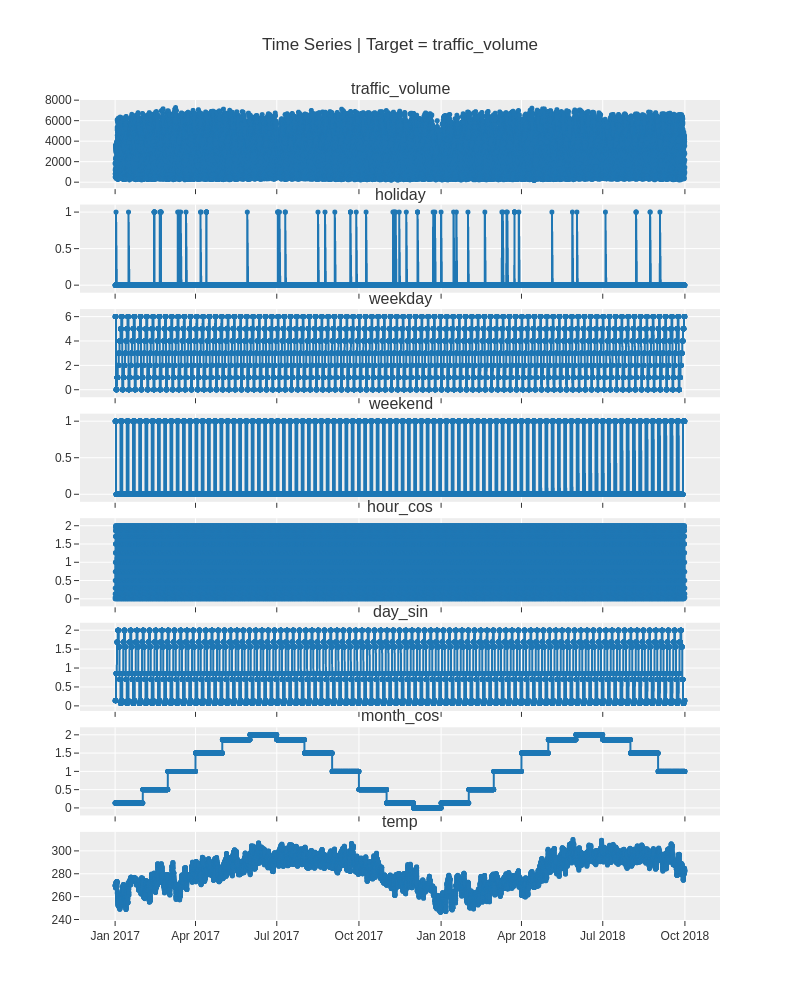

In [40]:
plot_model(plot = 'ts', fig_kwargs={"height": 1000, "width": 800})

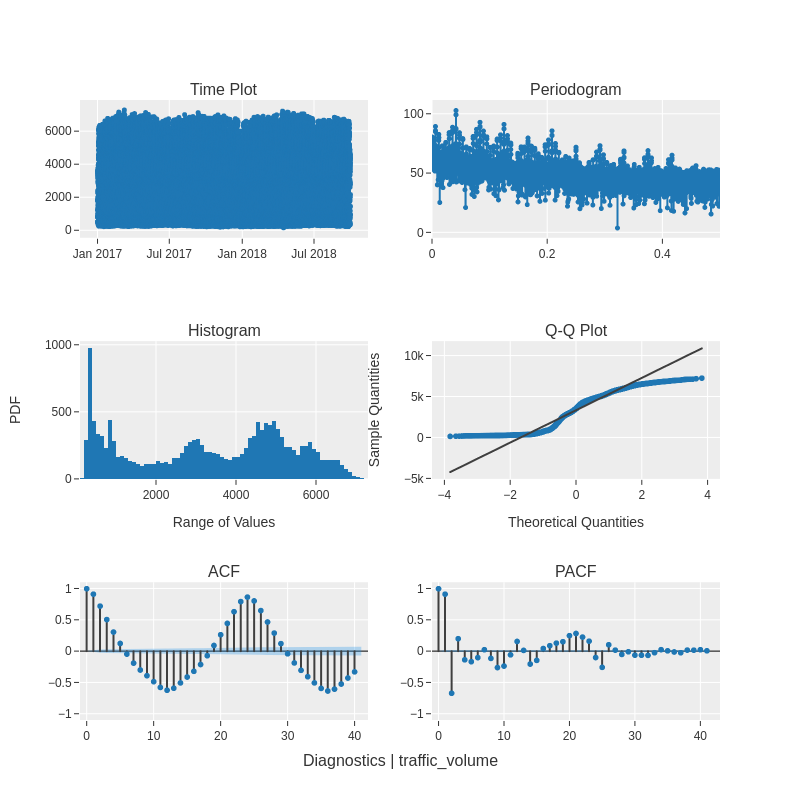

In [41]:
plot_model(plot='diagnostics', fig_kwargs={"height": 800, "width": 800})

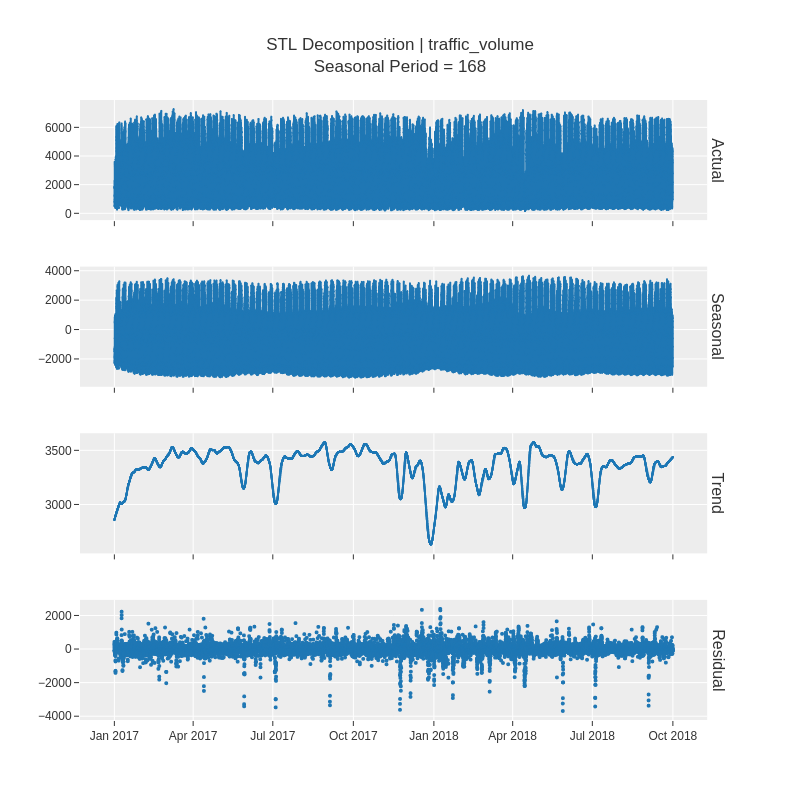

In [42]:
plot_model(plot = 'decomp_stl', fig_kwargs ={"height": 800, "width": 800})

#### Use only fast and more accurate models after preselection

In [43]:
select_models = [
    "lasso_cds_dt",
    "br_cds_dt",
    "huber_cds_dt",
    "omp_cds_dt",
    "catboost_cds_dt"
]

In [44]:
best3 = compare_models(
    include=select_models,
    sort="MAE",
    verbose=1,
    n_select=3
)

ValueError: ignored

In [ ]:
print(best3)

#### Blend 3 top models to make final model more stable

In [ ]:
blender = blend_models(best3)

In [ ]:
predictions = predict_model(blender)

##### Plot residuals

In [ ]:
# plot_model(blender, plot = 'residuals')

##### Plot predictions

In [ ]:
predictions.plot(label="traffic_predicted")
data[-24*7*2:]['traffic_volume'].plot(label="traffic volume")
plt.suptitle("Predicted vs actual traffic volume")
plt.legend()
plt.show()

In [ ]:
save_model(blender, 'saved_blender_model')

###  Let's try Gradient Boosting model from sklearn and plot prediction intervals


#### Define three regressors with quintile loss of 0.1, 0.5 and 0.9.

In [45]:
from sklearn.ensemble import GradientBoostingRegressor

In [50]:
# Set lower and upper quantile
LOWER_ALPHA = 0.1
UPPER_ALPHA = 0.9
n_estimators=100
max_depth=5
# Each model has to be separate
model = GradientBoostingRegressor(loss="quantile",                   
                                        alpha=LOWER_ALPHA, 
                                        n_estimators=n_estimators,
                                        max_depth=max_depth)
lower_model = GradientBoostingRegressor(loss="quantile",                   
                                        alpha=LOWER_ALPHA, 
                                        n_estimators=n_estimators,
                                        max_depth=max_depth)
# The mid model will use the default loss
mid_model = GradientBoostingRegressor(loss="ls", 
                                        n_estimators=n_estimators,
                                        max_depth=max_depth)
upper_model = GradientBoostingRegressor(loss="quantile",
                                        alpha=UPPER_ALPHA, 
                                        n_estimators=n_estimators,
                                        max_depth=max_depth)

In [51]:
models = [model, lower_model, mid_model, upper_model]

#### Define new pycaret setup

In [54]:
bs = setup(
    data=data,
    target="traffic_volume",
    enforce_exogenous=True,
    fold=3, #5
    fh=24 * 7,
    seasonal_period=24 * 7,
    session_id=random_state,
)

,Description,Value
0,session_id,17
1,Target,traffic_volume
2,Approach,Univariate
3,Exogenous Variables,Present
4,Data shape,"(15312, 8)"
5,Train data shape,"(15144, 8)"
6,Test data shape,"(168, 8)"
7,Fold Generator,ExpandingWindowSplitter
8,Fold Number,3
9,Enforce Prediction Interval,False


In [ ]:
# b = compare_models(
#     include=models,
#     sort="MAE",
#     verbose=1,
#     n_select=3
# )

In [58]:
lo = create_model("gbr_cds_dt",loss="quantile",                   
                                        alpha=LOWER_ALPHA, 
                                        n_estimators=n_estimators,
                                        max_depth=max_depth)

IntProgress(value=0, description='Processing: ', max=4)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,09:19:01
Status,. . . . . . . . . . . . . . . . . .,Selecting Estimator
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,cutoff,MAE,RMSE,MAPE,SMAPE,MASE,RMSSE,R2


TypeError: ignored

In [ ]:
print(aarima)

In [ ]:
pred_arima = predict_model(aarima, return_pred_int=True)

In [ ]:
plot_model(aarima, plot = 'forecast')

In [ ]:
pred_arima.head()

In [ ]:
predictions.plot(label="traffic_predicted")
data[-24*7*2:]['traffic_volume'].plot(label="traffic volume")
plt.suptitle("Auto ARIMA mode\nPredicted vs actual traffic volume")
plt.legend()
plt.show()

In [ ]:
save_model(aarima, 'saved_auto_arima_model')

### **NGBoost**

In [ ]:
%%capture
# !pip install --upgrade ngboost

In [ ]:
# from ngboost import NGBRegressor
# ngc = NGBRegressor()
# ngboost = create_model(ngc)
# ngb = create_model('ngboost')

In [ ]:
# print(ngboost)

### CONCLUSION

Time series models included with Pycaret failed to beat baseline model, but the library is fun to work with. When you need to explore data and build model fast, this is a library of choice.